In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn.model_selection import KFold

In [447]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'


trainset = pd.read_csv('trainset.csv', index_col=0)
testset = pd.read_csv('testset.csv', index_col=0)

In [463]:
trainset.head(5)

,movie,year,runtime,director,stars,imdb,gross,metascore,vote,budget,...,stars_20,stars_21,stars_22,stars_23,stars_24,stars_25,stars_26,stars_27,stars_28,stars_29
2198,Room 237,2012.0,102.0,0,0,6.2,259765,80.000000,20264,0.0,...,0,0,0,0,0,0,0,0,0,0
5388,Little Italy,2018.0,102.0,0,0,5.7,990230,28.000000,8254,0.0,...,0,0,0,0,0,0,0,0,0,0
2346,Heroine,2012.0,149.0,0,0,5.1,593344,58.788051,3822,0.0,...,0,0,0,0,0,0,0,0,0,0
3100,Interstellar,2014.0,169.0,1,1,8.6,188020017,74.000000,1388882,165000000.0,...,0,0,0,0,0,0,0,0,0,0
3406,The Single Moms Club,2014.0,111.0,1,0,5.3,15986272,31.000000,5585,8000000.0,...,0,0,0,0,0,0,0,0,0,0


In [449]:
header = list(trainset)
y_train = trainset['gross']
y_test = testset['gross']

header.remove('gross')
header.remove('metascore')
header.remove('imdb')
header.remove('vote')
# header.remove('budget')
# header.remove('day')
# header.remove('month')

X_train = trainset.loc[:, header[1:]]
X_test = testset.loc[:, header[1:]]

In [450]:
print(X_train.shape)
print(X_test.shape)

(4165, 182)
(1785, 182)


In [452]:
model = XGBRegressor()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

result=pd.DataFrame({'movie':testset['movie'] , 'label': y_test, 'prediction': [max(0,x) for x in prediction]})
r2 = r2_score(y_test, prediction)
print('r2_score: {}'.format(r2))

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

r2_score: 0.7603274857971023


In [453]:
result

,movie,label,prediction
1368,The Hammer,75729,3.515452e+06
967,Toe to Toe,21268,1.245511e+05
3184,St. Vincent,44134898,2.904635e+07
347,Downloading Nancy,22153,1.217460e+06
5226,Vice,47836282,1.073661e+08
...,...,...,...
3147,Dracula Untold,56280355,7.305617e+07
3911,Lao pao er,1415450,0.000000e+00
1897,Gianni e le donne,315307,0.000000e+00
4934,Tehran Taboo,74758,0.000000e+00


In [454]:
svc_rfr = cross_val_score(estimator=model,X=X_train,y=y_train,cv=KFold(n_splits=5), scoring='r2')
print(svc_rfr)
print(svc_rfr.mean())

[0.77965543 0.70392044 0.80355382 0.73150443 0.66417032]
0.7365608899361771


### Model tuning

In [464]:
# First round
model = XGBRegressor()
param = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=Non...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbos

0.7370734836334952
{'n_estimators': 200}


In [52]:
# Second round
model = XGBRegressor(n_estimators=100)
param = {'min_child_weight':[1,2,3,4,5,6]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=Non...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
         

0.9514851194056346
{'min_child_weight': 5}


In [53]:
# Third round
model = XGBRegressor(n_estimators=100, min_child_weight=5)
param = {'max_depth':[3,4,5,6,7,8,9,10]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=5,
                                    m...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsam

0.9521135182216781
{'max_depth': 4}


In [55]:
# Fourth round
model = XGBRegressor(n_estimators=100, min_child_weight=5, \
                      max_depth=4)
param = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=4, min_child_weight=5,
                                    miss...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsam

0.9526687580135524
{'gamma': 0.4}


In [57]:
# Fifth round
# alpha : L1 regularization   lambda: L2 regularization
model = XGBRegressor(n_estimators=100, min_child_weight=5, \
                      max_depth=4, gamma=0.4)
param = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=0.4,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=4, min_child_weight=5,
                                    missi...
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                

0.9520287947908791
{'reg_alpha': 0.05, 'reg_lambda': 1}


In [58]:
# Sixth round
model = XGBRegressor(n_estimators=100, min_child_weight=5, \
                      max_depth=4, gamma=0.4,\
                      reg_alpha=0.05, reg_lambda=1)
param = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=0.4,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=4, min_child_weight=5,
                                    missi...
                                    num_parallel_tree=None,
                                    objective='reg:squarederror',
                                    random_state=None, reg_alpha=0.05,
                                    reg_lambda=1, scale_pos_weight=None,
                                    subsample

0.9529460223807344
{'learning_rate': 0.1}


In [ ]:
# Seventh round
model = XGBRegressor(n_estimators=100, min_child_weight=5, \
                      max_depth=4, gamma=0.4,\
                      reg_alpha=0.05, reg_lambda=1)
param = {'eta': []}
gs = GridSearchCV(model, param, cv=KFold(n_splits=5))
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

### Final Testing

In [455]:
# Final testing
model = XGBRegressor(n_estimators=100, min_child_weight=5, \
                      max_depth=6, gamma=0.5,\
                      reg_alpha=1, reg_lambda=3,\
                      learning_rate=0.3)

model.fit(X_train, y_train)
prediction = model.predict(X_test)
# prediction = np.exp(prediction)

result=pd.DataFrame({'movie':testset['movie'] , 'label': y_test, 'prediction': [max(0,x) for x in prediction]})
r2 = r2_score(y_test, prediction)
print('r2_score: {}'.format(r2))

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=1,
             reg_lambda=3, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

r2_score: 0.7342384167638885


In [456]:
result

,movie,label,prediction
1368,The Hammer,75729,2.038877e+06
967,Toe to Toe,21268,0.000000e+00
3184,St. Vincent,44134898,2.705840e+07
347,Downloading Nancy,22153,0.000000e+00
5226,Vice,47836282,7.302786e+07
...,...,...,...
3147,Dracula Untold,56280355,6.704324e+07
3911,Lao pao er,1415450,3.782248e+06
1897,Gianni e le donne,315307,0.000000e+00
4934,Tehran Taboo,74758,0.000000e+00


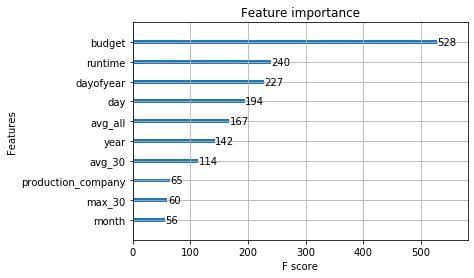

In [457]:
import xgboost as xgb
xgb.plot_importance(model, max_num_features=10)

### Visualization

In [458]:
model = XGBRegressor(n_estimators=100, min_child_weight=5, \
                      max_depth=6, gamma=5,\
                      reg_alpha=1, reg_lambda=3,\
                      learning_rate=0.3, subsample=0.8,\
                      colsample_bytree=1)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric='mae', eval_set=eval_set, verbose=True, early_stopping_rounds=10)

[0]	validation_0-mae:16440137.00000	validation_1-mae:16921694.00000
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:13477460.00000	validation_1-mae:14044617.00000
[2]	validation_0-mae:11776788.00000	validation_1-mae:12839543.00000
[3]	validation_0-mae:10686746.00000	validation_1-mae:12297891.00000
[4]	validation_0-mae:10014825.00000	validation_1-mae:11902783.00000
[5]	validation_0-mae:9434536.00000	validation_1-mae:11758029.00000
[6]	validation_0-mae:9175476.00000	validation_1-mae:11613048.00000
[7]	validation_0-mae:8928691.00000	validation_1-mae:11596983.00000
[8]	validation_0-mae:8719401.00000	validation_1-mae:11525640.00000
[9]	validation_0-mae:8672984.00000	validation_1-mae:11496875.00000
[10]	validation_0-mae:8498882.00000	validation_1-mae:11454531.00000
[11]	validation_0-mae:8320860.50000	validation_1-mae:11465274.00000
[12]	validation_0-mae:8216860.50

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=1,
             reg_lambda=3, scale_pos_weight=1, subsample=0.8, tree_method=None,
             validate_parameters=False, verbosity=None)

In [459]:
results = model.evals_result()

In [460]:
epochs = len(results['validation_0']['mae'])

Text(0, 0.5, 'Regression Error')

Text(0.5, 1.0, 'XGBoost Regression Error')

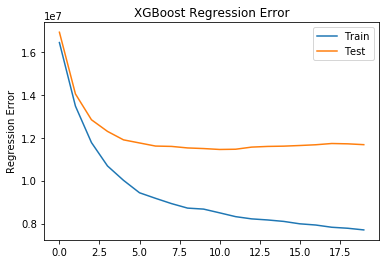

In [461]:
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('Regression Error')
plt.title('XGBoost Regression Error')
plt.show()

In [462]:
prediction = model.predict(X_test)
# prediction = np.exp(prediction)

result=pd.DataFrame({'movie':testset['movie'] , 'label': y_test, 'prediction': [max(0,x) for x in prediction]})
r2 = r2_score(y_test, prediction)
print('r2_score: {}'.format(r2))

r2_score: 0.735998073539999
